# Identifying Debts Worth Pursuing by the Bank

This Python notebook assesses the cost-effectiveness of assigning delinquent bank customers to different debt recovery strategies based on expected recovery amounts. It employs regression discontinuity analysis to determine if the increased earnings from such assignments outweigh the added costs. 

Regression discontinuity in banking recovery involves assessing the effectiveness of different recovery strategies for charged-off debts. These strategies are implemented at various thresholds based on the expected recovery amount. The bank increases its efforts as the expected recovery amount rises, for example, incurring an additional 50 dollars in cost per customer for each higher recovery level. 

Tasks like data exploration, statistical tests on factors like age and sex, and regression modeling are used to understand the relationship between these variables, providing insights into decision-making processes involving thresholds.

The dataset uses different recovery strategies at various thresholds (1000, 2000, 3000, and 5000) based on the Expected Recovery Amounts. Level 0 includes customers with Expected Recovery Amounts between 0 and 1000, while Level 1 covers those with amounts between 1001 and 2000, and so on until Level 4.

## Importing Libraries and Reading the Data

In [1]:
# Import modules
import pandas as pd
import numpy as np

# Read in dataset
df = pd.read_csv('datasets/bank_data.csv')

# Print the first few rows of the DataFrame
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


## Exploring the Data: Scatter Plot of Age vs. Expected Recovery Amount

Do factors other than Expected Recovery Amount, such as customer age, exhibit a discontinuity at the 1000-dollar threshold?
To investigate, a scatter plot of Age vs. Expected Recovery Amount in the 0 to 2000 range (encompassing Levels 0 and 1) can be examined.

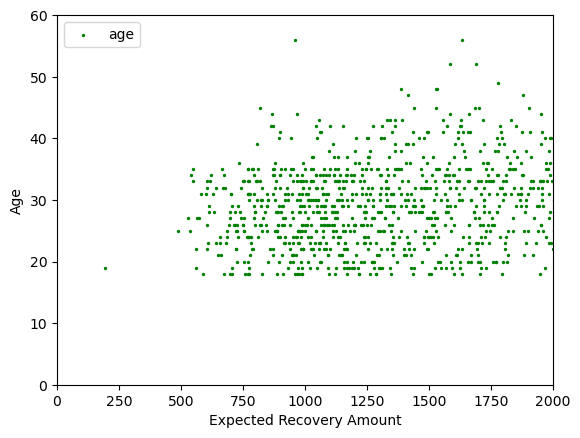

In [10]:
# Scatter plot of Age vs. Expected Recovery Amount
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2, label="age")
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(loc=2)
plt.show()

## Statistical Test: Age vs. Expected Recovery Amount

Ensuring that variables like age and sex are similar both above and below the 1000 dollar Expected Recovery Amount threshold is crucial to attribute differences in actual recovery amounts to the higher Recovery Strategy rather than other factors. 

The Kruskal-Wallis test can be used to assess the average age around the 900 to 1100 threshold. This test does not make distributional assumptions and aids in identifying age variances immediately above and below the threshold.

In [3]:
# Import stats module
from scipy import stats

# Compute average age just below and above the threshold
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

# Perform Kruskal-Wallis test 
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age, Level_1_age) 

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

##### Result Interpretation: 

Since the p-value is greater than the conventional significance level of 0.05, it suggests that there is no statistically significant difference in the age distributions just above and below the 1000-dollar Expected Recovery Amount threshold. 

##### The age factor does not appear to vary significantly between "Level 0 Recovery" and "Level 1 Recovery."

# Statistical Test: Sex vs. Expected Recovery Amount

Statistical methods like chi-square tests and cross-tabulations can explore if the distribution of male and female customers varies across different recovery strategies. Chi-square tests help determine if two categorical variables are independent or dependent, with a significant p-value indicating dependence.

In [4]:
# Number of customers in each category
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) &
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'],
                       df['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
p_val

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55


0.5377947810444592

##### Result Interpretation: 
Since the p-value is greater than the conventional significance level of 0.05, it suggests that there is no statistically significant difference in the distribution of male and female customers across recovery strategies.
##### The sex factor does not appear to vary significantly between "Level 0 Recovery" and "Level 1 Recovery." 

# Exploring the Recovery Amount

The crucial question is whether there's a noticeable jump (discontinuity) near the 1000-dollar threshold.

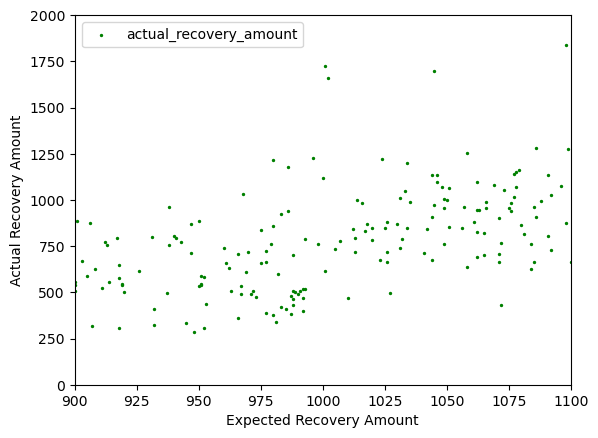

In [7]:
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount 
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2, label="actual_recovery_amount")
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.legend(loc=2)
plt.show()

# Statistical Test: Recovery Amount

In [11]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual, Level_1_actual) 

# Repeat for a smaller range of $950 to $1050
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = era_950_1050.loc[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']
stats.kruskal(Level_0_actual, Level_1_actual) 

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

##### Result Interpretation:  
Based on the high statistic of 30.246, the test strongly suggests a meaningful difference in actual recovery amounts between the two recovery levels within the specified Expected Recovery Amount range. It is supported by a very low p-value, that is exceptionally smaller than the conventional significance level of 0.05,  confirming a significant difference in actual recovery amounts. 

##### The Expected Recovery Amount factor appears to vary significantly between "Level 0 Recovery" and "Level 1 Recovery." 

# Regression Modeling: No Threshold

This regression model predicts actual recovery amount based on expected recovery amount, with the expectation of a strong positive relationship.
The assessment of adjusted R-squared will reveal how much variance is explained in this model, emphasizing the relationship between expected recovery amount and actual recovery amount, without including the threshold representation.

In [12]:
# Import statsmodels
import statsmodels.api as sm

# Define X and y
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Sun, 29 Oct 2023   Prob (F-statistic):           1.56e-13
Time:                            18:15:01   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Result Interpretation: We see that the expected recovery amount's regression coefficient is statistically significant.

# Regression Modeling: Adding True Threshold

This second regression model incorporates an indicator for the 1000-dollar threshold. By adding the true threshold to the model, the regression coefficient for the threshold quantifies the additional recovery attributed to the higher recovery strategy. Essentially, this coefficient gauges the size of the discontinuity for customers just above and below the threshold. 

If the higher recovery strategy led to increased recovery, the regression coefficient for the true threshold will be positive; otherwise, it won't be statistically significant.

In [14]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)

era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = era_900_1100[['expected_recovery_amount','indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Sun, 29 Oct 2023   Prob (F-statistic):           1.83e-15
Time:                            18:23:12   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Result Interpretation: 
The regression coefficient for the actual threshold showed statistical significance and had an estimated impact of approximately 278 dollars. 
##### This impact is considerably greater than the cost of 50 dollars per customer required to implement the higher recovery strategy.

# Regression Modeling: Adjusting the Window

To confirm that the previous result isn't influenced by the choice of the 900 to 1100 expected recovery amount window, the analysis can be repeated for the narrower 950 to 1050 window. 

In [15]:
# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]

# Define X and y 
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Sun, 29 Oct 2023   Prob (F-statistic):           1.12e-07
Time:                            18:28:11   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Result Interpretation: 
An estimated impact of approximately 286 dollars which is considerably greater than the cost of 50 dollars per customer required to implement the higher recovery strategy.
So, the outcome remains consistent whether using a wide or narrow window: the additional recovery from the higher strategy significantly exceeds the 50 dollar per customer cost. 

##### This affirms that the higher recovery strategy justifies the extra cost per customer expense.